In [1]:
#!cd .. && mkdir build
#!cd ../build/ && rm -rf *
#!cd ../build && cmake \
#  -DPYTHON_EXECUTABLE="$(which python)" \
#  -DCMAKE_BUILD_TYPE=Release ..
#!cd ../build && make install

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from itertools import cycle
import metnum
import utils

In [3]:
readDF = shuffle(pd.read_csv('../data/train.csv'), random_state = 120)
DF_TEST = readDF[0:72000].copy()
df_completo = readDF[72000:].copy()

In [4]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168000 entries, 40118 to 163495
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          168000 non-null  int64  
 1   titulo                      164222 non-null  object 
 2   descripcion                 166870 non-null  object 
 3   tipodepropiedad             167969 non-null  object 
 4   direccion                   130771 non-null  object 
 5   ciudad                      167743 non-null  object 
 6   provincia                   167894 non-null  object 
 7   antiguedad                  137443 non-null  float64
 8   habitaciones                152255 non-null  float64
 9   garages                     141637 non-null  float64
 10  banos                       149675 non-null  float64
 11  metroscubiertos             155793 non-null  float64
 12  metrostotales               132122 non-null  float64
 13  idzona    

In [5]:
## Hacemos prediccion de precio sobre el dataset completo

In [6]:
# Separamos las features del precio
df_completo_precio = df_completo['precio'].copy()
df_completo_features = df_completo.copy()
df_completo_features.pop('precio')

40118      479320.0
192538    1100000.0
172462    1974000.0
80897     1800000.0
91931     2950000.0
            ...    
208254    1725000.0
230111    4900000.0
83102     4500000.0
42752      600000.0
163495    2500000.0
Name: precio, Length: 168000, dtype: float64

In [7]:
#Sacamos las features categoricas
df_completo_features = df_completo_features.select_dtypes(['float64'])
df_completo_features.pop('idzona')

40118      66449.0
192538     56881.0
172462         NaN
80897          NaN
91931      56719.0
            ...   
208254     87716.0
230111    286424.0
83102      32742.0
42752      57677.0
163495     24795.0
Name: idzona, Length: 168000, dtype: float64

In [8]:
#Corremos con crossval
utils.kFoldCrossValidation(df_completo_features, df_completo_precio)

[2793686.513560164, 14.297325877336993]

In [9]:
#Pasamos a ver la correlacion de las variables

<AxesSubplot:>

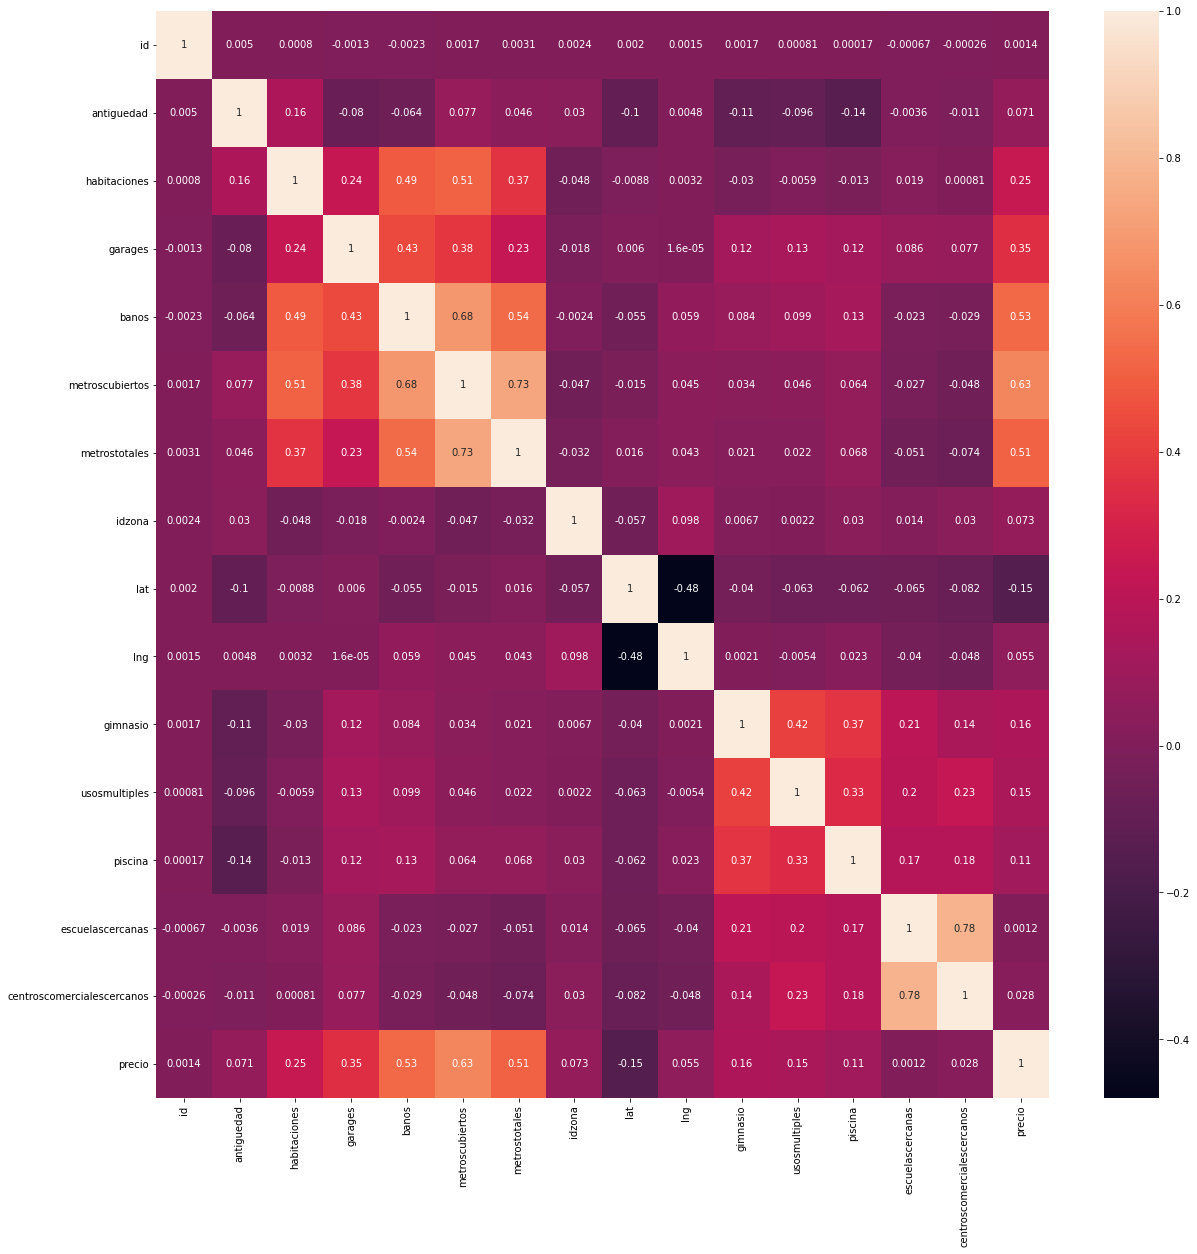

In [10]:
df_completo_corr = df_completo.copy()
plt.figure(figsize=(20, 20))
sns.heatmap(df_completo_corr.corr(), annot = True)

In [11]:
#Me quedo solo con las features que quiero usar (>=0.25) y (>0.50)
df_completo_corr_25 = df_completo[['habitaciones','garages','banos','metroscubiertos','metrostotales','precio']]
df_completo_corr_25 = df_completo_corr_25.dropna()
df_completo_corr_25_features = df_completo_corr_25[['habitaciones','garages','banos','metroscubiertos','metrostotales']]
df_completo_corr_25_precio = df_completo_corr_25['precio']

In [12]:
#Corremos el modelo
utils.kFoldCrossValidation(df_completo_corr_25_features, df_completo_corr_25_precio)

[1312663.518336841, 0.5598523396766063]

In [13]:
#Me quedo solo con las features que quiero usar (>0.50)
df_completo_corr_50 = df_completo[['banos','metroscubiertos','metrostotales','precio']]
df_completo_corr_50 = df_completo_corr_50.dropna()
df_completo_corr_50_features = df_completo_corr_50[['banos','metroscubiertos','metrostotales']]
df_completo_corr_50_precio = df_completo_corr_50['precio']

In [14]:
#Con crossVal
utils.kFoldCrossValidation(df_completo_corr_50_features, df_completo_corr_50_precio)

[1420454.5250194068, 0.5778746781073429]

In [15]:
#Vemos usando LASSO

In [16]:
df_completo_lasso = df_completo.select_dtypes(['float64'])
df_completo_lasso.pop('idzona')
df_completo_lasso = df_completo_lasso.dropna()
df_completo_lasso_features = df_completo_lasso.copy()
df_completo_lasso_features.pop('precio')
df_completo_lasso_precio = df_completo_lasso['precio']

0.0
-0.0
0.01139243991617357
0.004866356253417327
0.005665900543302934
0.0021455366629413563
-0.052310103789133
-0.010288090134037161
0.0
0.0
0.0
0.0
0.0


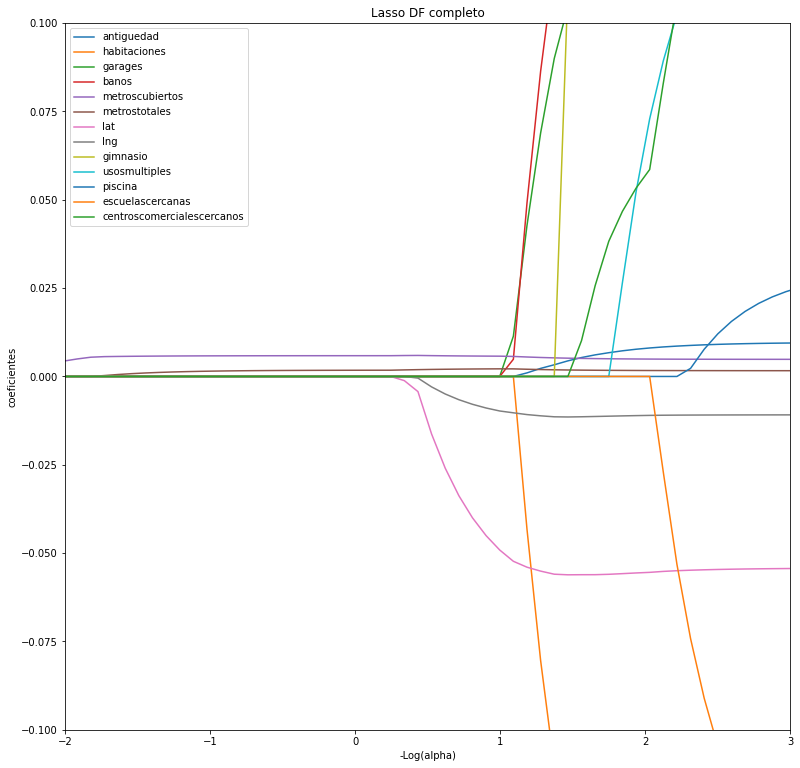

In [17]:
df_completo_lasso_precio_2 = df_completo_lasso_precio / df_completo_lasso_precio.std(axis=0)

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(df_completo_lasso_features,df_completo_lasso_precio_2,eps = 5e-10, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

colors = cycle(['olive', 'black', 'black', 'green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'black', 'black', 'black', 'black', 'orange'])
plt.figure(figsize=(13, 13))

lineas = []
for coef_l, c in zip(coefs_lasso, colors):
    lineas.append(plt.plot(neg_log_alphas_lasso, coef_l))
    print(coef_l[37])

plt.xlabel('-Log(alpha)')
plt.ylabel('coeficientes')
plt.title('Lasso DF completo')
plt.legend(df_completo_lasso_features.columns.values)
plt.axis('tight')
plt.ylim(-0.1,0.1)
plt.xlim(-2,3)
plt.show()

In [18]:
#Nos quedamos con las 6 mejores features
df_completo_lasso_features_filtrado = df_completo_lasso_features[['metrostotales','metroscubiertos','lng','lat','garages','banos']]

In [19]:
#Corremos el modelo
utils.kFoldCrossValidation(df_completo_lasso_features_filtrado, df_completo_lasso_precio)

[1327527.7619148516, 0.571923453047583]

In [20]:
########
#Creamos nuevas variables (Feature Engineering)

In [21]:
#Creamos dataset que contendra los features agregados
#Lo hago sobre el completo para ver las correlaciones, despues se popea lo que se tenga que popear
df_completo_engineering = df_completo.copy()

In [22]:
#Agregamos longitud de descripciones
descripciones = df_completo_engineering.descripcion.str.split(' ').str.len()
df_completo_engineering['longitud_descripciones'] = descripciones
#Lo agregamos a TEST
descripciones = DF_TEST.descripcion.str.split(' ').str.len()
DF_TEST['longitud_descripciones'] = descripciones

In [23]:
#Agregamos rating familiar
df_completo_engineering['rating_familiar'] = 2**( (df_completo['habitaciones']) + (df_completo['banos']) ) + 2 * df_completo['metroscubiertos'] + 25 * df_completo['escuelascercanas']
#Lo agregamos a TEST
DF_TEST['rating_familiar'] = 2**( (DF_TEST['habitaciones']) + (DF_TEST['banos']) ) + 2 * DF_TEST['metroscubiertos'] + 25 * DF_TEST['escuelascercanas']

In [24]:
#Sacamos las categoricas
df_completo_engineering = df_completo_engineering.select_dtypes(['float64'])
df_completo_engineering.pop('idzona')

40118      66449.0
192538     56881.0
172462         NaN
80897          NaN
91931      56719.0
            ...   
208254     87716.0
230111    286424.0
83102      32742.0
42752      57677.0
163495     24795.0
Name: idzona, Length: 168000, dtype: float64

<AxesSubplot:>

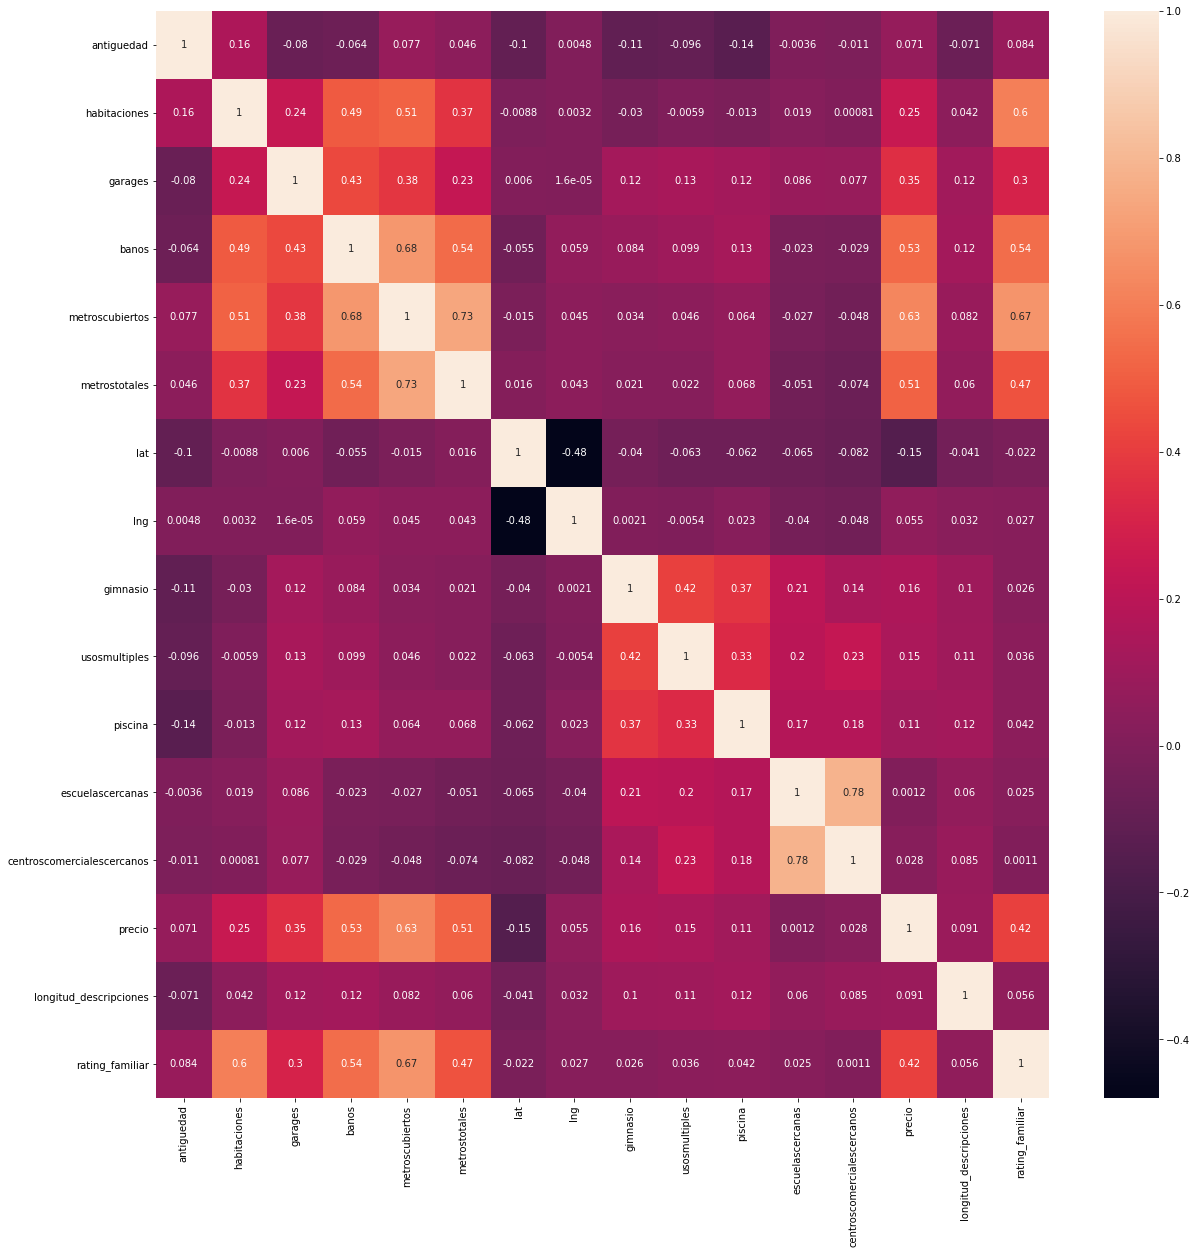

In [25]:
#Vemos la correlacion de estos nuevos features
plt.figure(figsize=(20, 20))
sns.heatmap(df_completo_engineering.corr(), annot = True)
#LongitudDescripciones tiene corr de 0.092
#RatingFamiliar tiene corr de 0.42

In [26]:
#Me quedo solo con las features que quiero usar (>=0.25) y (>0.50)
df_eng_corr_25 = df_completo_engineering[['habitaciones','garages','banos','metroscubiertos','metrostotales','precio','rating_familiar']]
df_eng_corr_25 = df_eng_corr_25.dropna()
df_eng_corr_25_features = df_eng_corr_25[['habitaciones','garages','banos','metroscubiertos','metrostotales','rating_familiar']]
df_eng_corr_25_precio = df_eng_corr_25['precio']

In [27]:
#Corremos el modelo
utils.kFoldCrossValidation(df_eng_corr_25_features, df_eng_corr_25_precio)

[1312389.7662523545, 0.5635973182770326]

In [28]:
#Preparo el df para hacer LASSO
df_completo_engineering_lasso = df_completo_engineering.dropna()
df_completo_engineering_lasso_features = df_completo_engineering_lasso.copy()
df_completo_engineering_lasso_features.pop('precio')
df_completo_engineering_lasso_precio = df_completo_engineering_lasso['precio']

0.0
-0.0
0.001677489445644973
0.0028846850458816155
0.006080449883513862
0.0021373679784886016
-0.05179539627290397
-0.009866005799060438
0.0
0.0
0.0
0.0
0.0
0.000748015629789486
-0.00015480208709677982


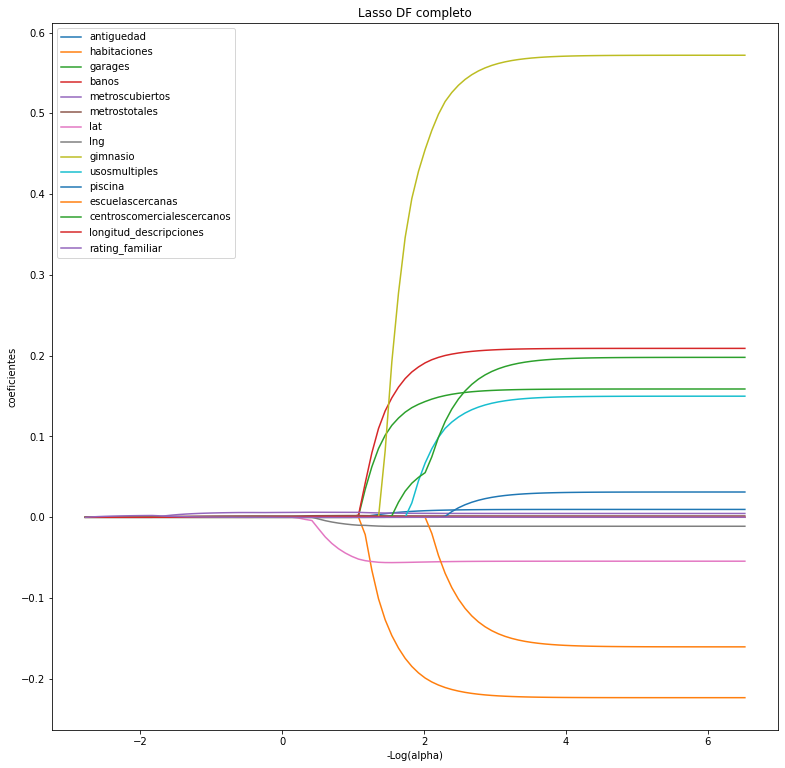

In [29]:
df_completo_engineering_lasso_precio_2 = df_completo_engineering_lasso_precio / df_completo_engineering_lasso_precio.std(axis=0)

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(df_completo_engineering_lasso_features,df_completo_engineering_lasso_precio_2,eps = 5e-10, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

colors = cycle(['red', 'blue', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'red', 'white', 'white', 'white'])
plt.figure(figsize=(13, 13))

lineas = []
for coef_l, c in zip(coefs_lasso, colors):
    lineas.append(plt.plot(neg_log_alphas_lasso, coef_l))
    print(coef_l[41])

plt.xlabel('-Log(alpha)')
plt.ylabel('coeficientes')
plt.title('Lasso DF completo')
plt.legend(df_completo_engineering_lasso_features.columns.values)
plt.axis('tight')

plt.show()

In [30]:
df_completo_engineering_lasso_features = df_completo_engineering_lasso_features[['metroscubiertos','metrostotales','longitud_descripciones','rating_familiar','lat','lng']]

In [31]:
#Corremos el modelo
utils.kFoldCrossValidation(df_completo_engineering_lasso_features, df_completo_engineering_lasso_precio)

[1358539.168739828, 0.5785181611756675]

In [32]:
#Segmentamos

In [33]:
#Comenzamos segmentando por ciudad usando corr25
df_ciudad = df_eng_corr_25_features.copy()
df_ciudad['ciudad'] = df_completo['ciudad']
df_ciudad['precio'] = df_completo['precio']

In [34]:
#Vamos a ver los resultados para las 3 ciudades con mas datos
df_ciudad['ciudad'].value_counts().head(3)

Querétaro        5636
Zapopan          4939
Benito Juárez    3848
Name: ciudad, dtype: int64

In [35]:
#Zapopan
df_zapo = df_ciudad[df_ciudad['ciudad']=='Zapopan'].dropna().copy()
df_zapo_features = df_zapo.copy()
df_zapo_features.pop('precio')
df_zapo_features.pop('ciudad')
#Queretaro
df_queta = df_ciudad[df_ciudad['ciudad']=='Querétaro'].dropna().copy()
df_queta_features = df_queta.copy()
df_queta_features.pop('precio')
df_queta_features.pop('ciudad')
#Benito Juarez
df_benito = df_ciudad[df_ciudad['ciudad']=='Benito Juárez'].dropna().copy()
df_benito_features = df_benito.copy()
df_benito_features.pop('precio')
df_benito_features.pop('ciudad')

16183     Benito Juárez
185597    Benito Juárez
90110     Benito Juárez
86718     Benito Juárez
98680     Benito Juárez
              ...      
199991    Benito Juárez
110539    Benito Juárez
88333     Benito Juárez
12865     Benito Juárez
229948    Benito Juárez
Name: ciudad, Length: 3848, dtype: object

In [36]:
#Para zapopan
utils.kFoldCrossValidation(df_zapo_features, df_zapo['precio'])

[834448.1644694477, 0.38308985482443314]

In [37]:
#Para Quetaro
utils.kFoldCrossValidation(df_queta_features, df_queta['precio'])

[533032.7902699406, 0.2425902849037474]

In [38]:
#Para Benito Juarez
utils.kFoldCrossValidation(df_benito_features, df_benito['precio'])

[1285045.1725607861, 0.39250127138961344]

In [39]:
#Separamos por tipo de propiedad

In [40]:
df = df_eng_corr_25_features.copy()
df['tipodepropiedad'] = df_completo['tipodepropiedad']
df['precio'] = df_completo['precio']

In [41]:
df['tipodepropiedad'].value_counts().head(2)

Casa           68781
Apartamento    18340
Name: tipodepropiedad, dtype: int64

In [42]:
#Casa
df_casa = df[df['tipodepropiedad']=='Casa'].dropna().copy()
df_casa_features = df_casa.copy()
df_casa_features.pop('precio')
df_casa_features.pop('tipodepropiedad')
#Apartamento
df_apartamento = df[df['tipodepropiedad']=='Apartamento'].dropna().copy()
df_apartamento_features = df_apartamento.copy()
df_apartamento_features.pop('precio')
df_apartamento_features.pop('tipodepropiedad')

16183     Apartamento
176533    Apartamento
133807    Apartamento
18009     Apartamento
194568    Apartamento
             ...     
112014    Apartamento
10601     Apartamento
38551     Apartamento
118072    Apartamento
131631    Apartamento
Name: tipodepropiedad, Length: 18340, dtype: object

In [43]:
#Para casa
utils.kFoldCrossValidation(df_casa_features, df_casa['precio'])

[1003084.8449026095, 0.4517739450585852]

In [44]:
#Para apartamento
utils.kFoldCrossValidation(df_apartamento_features, df_apartamento['precio'])

[1413506.0629510176, 0.5571813428795489]

In [ ]:
#Segmentamos por ambas

In [45]:
#Segmentamos por ciudad y por tipo de propiedad
df_ciudad['tipodepropiedad'] = df_completo['tipodepropiedad']
df_zapo_prop = df_ciudad[df_ciudad['ciudad']=='Zapopan'].copy()

In [46]:
#Vemos la cantidad de datos por tipo de propiedad
df_zapo_prop['tipodepropiedad'].value_counts().head(2)

Casa           3661
Apartamento     639
Name: tipodepropiedad, dtype: int64

In [47]:
#Separamos por casa y por apartamento
df_zapo_casa = df_zapo_prop[df_zapo_prop['tipodepropiedad']=='Casa'].dropna().copy()
df_zapo_condo = df_zapo_prop[df_zapo_prop['tipodepropiedad']=='Casa en condominio'].dropna().copy()
df_zapo_casa.pop('ciudad')
df_zapo_condo.pop('ciudad')
df_zapo_casa.pop('tipodepropiedad')
df_zapo_condo.pop('tipodepropiedad')
#Separamos en features y precio
df_zapo_condo_precio = df_zapo_condo['precio']
df_zapo_condo.pop('precio')
df_zapo_casa_precio = df_zapo_casa['precio']
df_zapo_casa.pop('precio')
print('Data set listo')

Data set listo


In [48]:
#Para casa
utils.kFoldCrossValidation(df_zapo_casa, df_zapo_casa_precio)

[738350.6435164509, 0.34262678559235626]

In [49]:
#Para casa en condominio
utils.kFoldCrossValidation(df_zapo_condo, df_zapo_condo_precio)

[656335.3924954851, 0.26392178647595144]

In [50]:
#Vemos los resultados corriendo en el df de Test

In [51]:
#Corremos en el df de test
df_test_seg = DF_TEST.copy()
df_test_seg = df_test_seg[['ciudad','tipodepropiedad','habitaciones','garages','banos','metroscubiertos','metrostotales','precio','rating_familiar']]

In [52]:
#Vemos cual es la ciudad con mas datos
df_test_seg['ciudad'].value_counts().head(3)

Querétaro        3764
Benito Juárez    3328
Zapopan          3063
Name: ciudad, dtype: int64

In [1]:
#Preparamos el dataset de test para correr el modelo usando las features preferidas
df_test_queta = df_test_seg[df_test_seg['ciudad']=='Querétaro']
df_test_queta['tipodepropiedad'].value_counts().head()

NameError: name 'df_test_seg' is not defined

In [54]:
#Preparamos el df
queta_casa = df_test_queta[df_test_queta['tipodepropiedad']=='Casa']
queta_casa = queta_casa.select_dtypes(['float64'])
queta_casa = queta_casa.dropna()
queta_casa_precio = queta_casa['precio']
queta_casa.pop('precio')
print('Dataset listo')

Dataset listo


In [55]:
#Corremos el modelo para la segmentacion queta/casa
utils.correr_modelo(queta_casa,queta_casa_precio)

El error RMSE es 473143.71959024423
El error RMSLE es 0.22793997734763458


In [56]:
#Ahora para 'Casa en condominio'

In [57]:
#Preparamos el df
queta_condo = df_test_queta[df_test_queta['tipodepropiedad']=='Casa en condominio']
queta_condo = queta_condo.select_dtypes(['float64'])
queta_condo = queta_condo.dropna()
queta_condo_precio = queta_condo['precio']
queta_condo.pop('precio')
print('Dataset listo')

Dataset listo


In [58]:
#Corremos el modelo para la segmentacion queta/condominio
utils.correr_modelo(queta_condo,queta_condo_precio)

El error RMSE es 396866.59872031095
El error RMSLE es 0.20999727931781123


In [59]:
#Por ultimo para 'Terreno'

In [60]:
#Preparamos el df
queta_terr = df_test_queta[df_test_queta['tipodepropiedad']=='Casa en condominio']
queta_terr = queta_terr.select_dtypes(['float64'])
queta_terr = queta_terr.dropna()
queta_terr_precio = queta_terr['precio']
queta_terr.pop('precio')
print('Dataset listo')

Dataset listo


In [61]:
#Corremos el modelo para la segmentacion queta/terreno
utils.correr_modelo(queta_terr,queta_terr_precio)

El error RMSE es 396866.59872031095
El error RMSLE es 0.20999727931781123
